# Article summarizer using an LSTM model with an attention layer.

Tutorial followed: https://github.com/aravindpai/How-to-build-own-text-summarizer-using-deep-learning/blob/master/How_to_build_own_text_summarizer_using_deep_learning.ipynb

NOTE: Check np.argmax function -- may be stuck on same index.

In [ ]:
dbutils.fs.mount(
    source = "wasbs://nlpsummarizercontainer@uwtaiproject2024summer.blob.core.windows.net",
    mount_point = '/mnt/blobstorage',
    extra_configs = "put actual key here when operating in azure"
)

Mounted at /content/drive


In [ ]:
# IMPORTING LIBRARIES
'''
NOTE: You must right click the shared folder named "NLP_Summarization"
    and select "Add shortcut to Drive". The shared folder will automatically
    be placed in your MyDrive so Google Colab can access its contents.
    (See https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab)
'''

import numpy as np
import pandas as pd
import nltk
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

# Load files from shared folder
%cd '/content/drive/MyDrive/NLP_Summarizer'
!cp /content/drive/MyDrive/NLP_Summarizer/attention.py /content/


from attention import AttentionLayer # Custom Attention layer by thushv89 on GitHub

[Errno 2] No such file or directory: '/content/drive/MyDrive/NLP_Summarizer'
/content
cp: cannot stat '/content/drive/MyDrive/NLP_Summarizer/attention.py': No such file or directory


ModuleNotFoundError: ignored

In [ ]:
# READ DATASET

data=pd.read_csv("/content/drive/MyDrive/NLP_Summarizer/new_train.csv")

In [ ]:
# REMOVE DUPLICATES AND N/A VALUES

data.drop_duplicates(subset=['article'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          5000 non-null   object
 1   article     5000 non-null   object
 2   highlights  5000 non-null   object
dtypes: object(3)
memory usage: 156.2+ KB


In [ ]:
# CONTRACTION MAPPING FOR PREPROCESSING

contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}


In [ ]:
# FUNCTION FOR PREPROCESSING DATA

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:
            long_words.append(i)
    return (" ".join(long_words)).strip()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# PREPROCESS ARTICLE TEXT

cleaned_text = []
for t in data['article']:
    cleaned_text.append(text_cleaner(t,0))

In [ ]:
cleaned_text[:5]

['associated press published est october updated est october bishop fargo catholic diocese north dakota exposed potentially hundreds church members fargo grand forks jamestown hepatitis virus late september early october state health department issued advisory exposure anyone attended five churches took communion bishop john folda fargo catholic diocese north dakota exposed potentially hundreds church members fargo grand forks jamestown hepatitis state immunization program manager molly howell says risk low officials feel important alert people possible exposure diocese announced monday bishop john folda taking time diagnosed hepatitis diocese says contracted infection contaminated food attending conference newly ordained bishops italy last month symptoms hepatitis include fever tiredness loss appetite nausea abdominal discomfort fargo catholic diocese north dakota bishop located',
 'ralph mata internal affairs lieutenant miami dade police department working division investigates alleg

In [ ]:
# PREPROCESS SUMMARIES TEXT

cleaned_summary = []
for t in data['highlights']:
    cleaned_summary.append(text_cleaner(t,1))

In [ ]:
cleaned_summary[:10]

['bishop john folda of north dakota is taking time off after being diagnosed he contracted the infection through contaminated food in italy church members in fargo grand forks and jamestown could have been exposed',
 'criminal complaint cop used his role to help cocaine traffickers ralph mata an internal affairs lieutenant allegedly helped group get guns he also arranged to pay two assassins in murder plot complaint alleges',
 'craig eccleston todd had drunk at least three pints before driving car was using phone when he veered across road in yarmouth isle of wight crashed head on into year old rachel titley car who died in hospital police say he would have been over legal drink drive limit at time of crash he was found guilty at portsmouth crown court of causing death by dangerous driving',
 'nina dos santos says europe must be ready to accept sanctions will hurt both sides targeting russia business community would be one way of sapping their support for president putin she says but s

In [ ]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

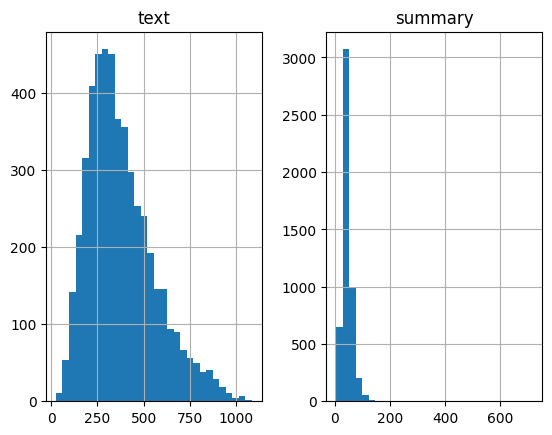

In [ ]:
# ANALYZING SENTENCE LENGTHS

import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# Populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [ ]:
# From the graph, most summaries are less than 60 words.
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<= 60):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.8432


In [ ]:
# CREATE MAXIMUM LENGTHS BASED ON WORD LENGTHS IN GRAPHS

max_text_len=375
max_summary_len=60

In [ ]:
# KEEP ONLY THE REVIEWS AND SUMMARIES THAT ARE WITHIN RANGE (see previous cell)

cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [ ]:
# ADD START (sostok) AND END (eostok) TOKENS

df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [ ]:
# SPLIT DATASET INTO TRAINING (0.8) AND VALIDATION SETS (0.2)

from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.2,random_state=0,shuffle=True)


In [ ]:
# CREATE TOKENIZERS FOR ARTICLE AND SUMMARIES/HIGHLIGHTS

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Prepare a tokenizer for articles on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
# RARE WORD OCCURRENCES (freq under 4 is rare)
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 58.651459803128745
Total Coverage of rare words: 6.43151523274355


In [ ]:
# DEFINE TOKENIZER WITH TOP MOST COMMON WORDS FOR ARTICLES

# Prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
x_tokenizer.fit_on_texts(list(x_tr))

# Ponvert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

# Padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# Size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print(x_voc)

14829


In [ ]:
# Prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
# Rarewords and coverage in summaries (freq under 6 is rare)
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 84.2921686746988
Total Coverage of rare words: 23.03097185903126


In [ ]:
# MAKE TOKENIZER WITH TOP MOST COMMON WORDS FOR SUMMARIES

#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [ ]:
# Check if word count of start token == length of training data set
y_tokenizer.word_counts['sostok'],len(y_tr)

(2041, 2041)

In [ ]:
# Delete rows with only start and end tokens
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [ ]:
#MODEL BUILDING

from keras import backend as K
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 375)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 375, 100)     1482900     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 375, 300),   481200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [ ]:
# COMPILE MODEL

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
# EARLY STOPPING (stop training when validation loss increases)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
# TRAINING THE MODEL

history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=3,callbacks=[es],batch_size=50, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/3
41/41 [==============================] - 276s 6s/step - loss: 4.0909 - val_loss: 3.2553
Epoch 2/3
41/41 [==============================] - 255s 6s/step - loss: 3.3291 - val_loss: 3.1647
Epoch 3/3
41/41 [==============================] - 249s 6s/step - loss: 3.2647 - val_loss: 3.1263


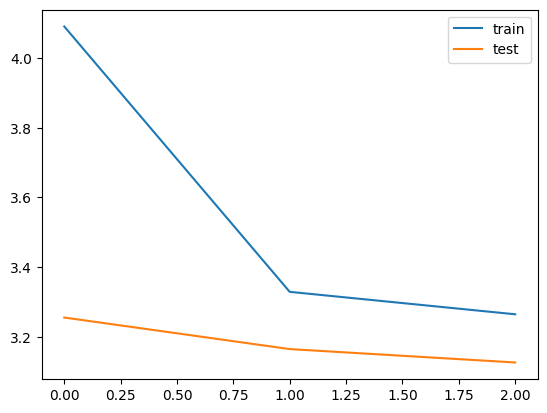

In [ ]:
# VIEW DIAGNOSTIC PLOT

from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# DICTIONARY TO CONVERT INDEX TO WORD

reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# INFERENCE FOR ENCODER AND DECODER

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
# generate a sequence from a language model
# def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
#   result = list()
#   in_text = seedtext
#   # generate a fixed number of words
#   for  in range(n_words):
#     # encode the text as integer
#     encoded = tokenizer.texts_to_sequences([in_text])[0]
#     # truncate sequences to a fixed length
#     encoded = pad_sequences([encoded], maxlen=seq_length, truncating= 'pre')
#     # predict probabilities for each word
#     yhat = np.argmax(model.predict(encoded, verbose=0), axis=-1)
#     # map predicted word index to word
#     out_word = ''
#     for word, index in tokenizer.word_index.items():
#      if index == yhat:
#        out_word = word
#        break
#     # append to input
#     in_text += ' ' + out_word
#     result.append(out_word)
#   return ' '.join(result)

In [ ]:
# FUNCTION IMPLEMENTING INFERENCE PROCESS

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.amax(output_tokens[0, -1, :])

        # Add print statement for index
        print('DECODE SEQUENCE: %s\n\tlSAMPLED TOKEN INDEX: %i\n' % (decoded_sentence, sampled_token_index))

        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
# FUNCTION TO CONVER INTEGER SEQUENCE TO A WORD SEQUENCE (for articles and summaries)

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
# SHOW SOME GENERATED SUMMARIES

for i in range(0,3):
    print("Article:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Article: called cure rejection letter fatigue amazon thursday released new details success program authors want self publish kindle reader devices company unveiled suite new readers tablets press conference southern california thursday says top kindle books created using system called kindle direct publishing system allows authors traditional publishers instead deal directly amazon claims able publish books digitally hours authors receive sale books quite well months six figure months said hugh howey year old florida author whose wool series digital books highlighted amazon ever hoped make year company says authors including theresa appeared promotional video amazon event sold hundreds thousands books event amazon ceo jeff bezos displayed quote author best selling novel help rejected dozens times publisher accepted given even quoted saying thing occurs said according live blog many authors stop many great manuscripts sitting somewhere fact many self published books successful amazon ec

KeyError: ignored